# 操作1

In [1]:
%%HTML
<style>
    body {
        --vscode-font-family: 霞鹜文楷, Consolas, 'Courier New', monospace
    }
</style>

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch

In [4]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

In [5]:
from pts.model.time_grad import TimeGradEstimator
from pytorch_lightning import Trainer

In [6]:
from diffusers import DEISMultistepScheduler

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

# 数据准备

In [9]:
# exchange_rate_nips, solar_nips, traffic_nips, solar_nips, wiki-rolling_nips, ## taxi_30min is buggy still
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
dataset_solar = get_dataset("solar_nips", regenerate=False)

In [10]:
dataset_solar.metadata


MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='137')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [11]:
train_grouper_solar = MultivariateGrouper(max_target_dim=min(2000, int(dataset_solar.metadata.feat_static_cat[0].cardinality)))

test_grouper_solar = MultivariateGrouper(num_test_dates=int(len(dataset_solar.test)/len(dataset_solar.train)), 
                                   max_target_dim=min(2000, int(dataset_solar.metadata.feat_static_cat[0].cardinality)))

In [12]:
dataset_train_solar = train_grouper_solar(dataset_solar.train)
dataset_test_solar = test_grouper_solar(dataset_solar.test)


In [13]:
scheduler = DEISMultistepScheduler(
    num_train_timesteps=150,
    beta_end=0.1,
)

In [14]:
estimator_solar = TimeGradEstimator(
    input_size=int(dataset_solar.metadata.feat_static_cat[0].cardinality),
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    lags_seq=[1],
    scheduler=scheduler,
    num_inference_steps=149,
    prediction_length=dataset_solar.metadata.prediction_length,
    context_length=dataset_solar.metadata.prediction_length * 3,
    freq=dataset_solar.metadata.freq,
    scaling="mean",
    trainer_kwargs=dict(max_epochs=2, accelerator="gpu", devices="1"),
)


# 训练开始

In [15]:
predictor_solar = estimator_solar.train(dataset_train_solar, num_workers=8)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type          | Params | Mode  | In sizes                                                             | Out sizes        
-------------------------------------------------------------------------------------------------------------------------------------------
0 | model | TimeGradModel | 186 K  | train | [[1, 1], [1, 1], [1, 72, 5], [1, 72, 137], [1, 72, 137], [1, 24, 5]] | [1, 100, 24, 137]
--------------------------------------------------------------------------

Epoch 0: |          | 50/? [00:13<00:00,  3.65it/s, v_num=21, train_loss=0.344]

Epoch 0, global step 50: 'train_loss' reached 0.34429 (best 0.34429), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_21/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:12<00:00,  3.91it/s, v_num=21, train_loss=0.111]

Epoch 1, global step 100: 'train_loss' reached 0.11089 (best 0.11089), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_21/checkpoints/epoch=1-step=100.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: |          | 50/? [00:12<00:00,  3.89it/s, v_num=21, train_loss=0.111]


In [16]:
forecast_it_solar, ts_it_solar = make_evaluation_predictions(dataset=dataset_test_solar,
                                                 predictor=predictor_solar,
                                                 num_samples=10)


In [17]:
forecasts_solar = list(forecast_it_solar)
targets_solar = list(ts_it_solar)

In [22]:
targets_solar

[                  0    1    2    3    4    5    6    7    8    9    ...  127  \
 2006-01-01 00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
 2006-01-01 01:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
 2006-01-01 02:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
 2006-01-01 03:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
 2006-01-01 04:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
 ...               ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
 2006-10-20 20:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
 2006-10-20 21:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
 2006-10-20 22:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
 2006-10-20 23:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
 2006-10-21 00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
 
                   128  12

# 画出预测图

solar


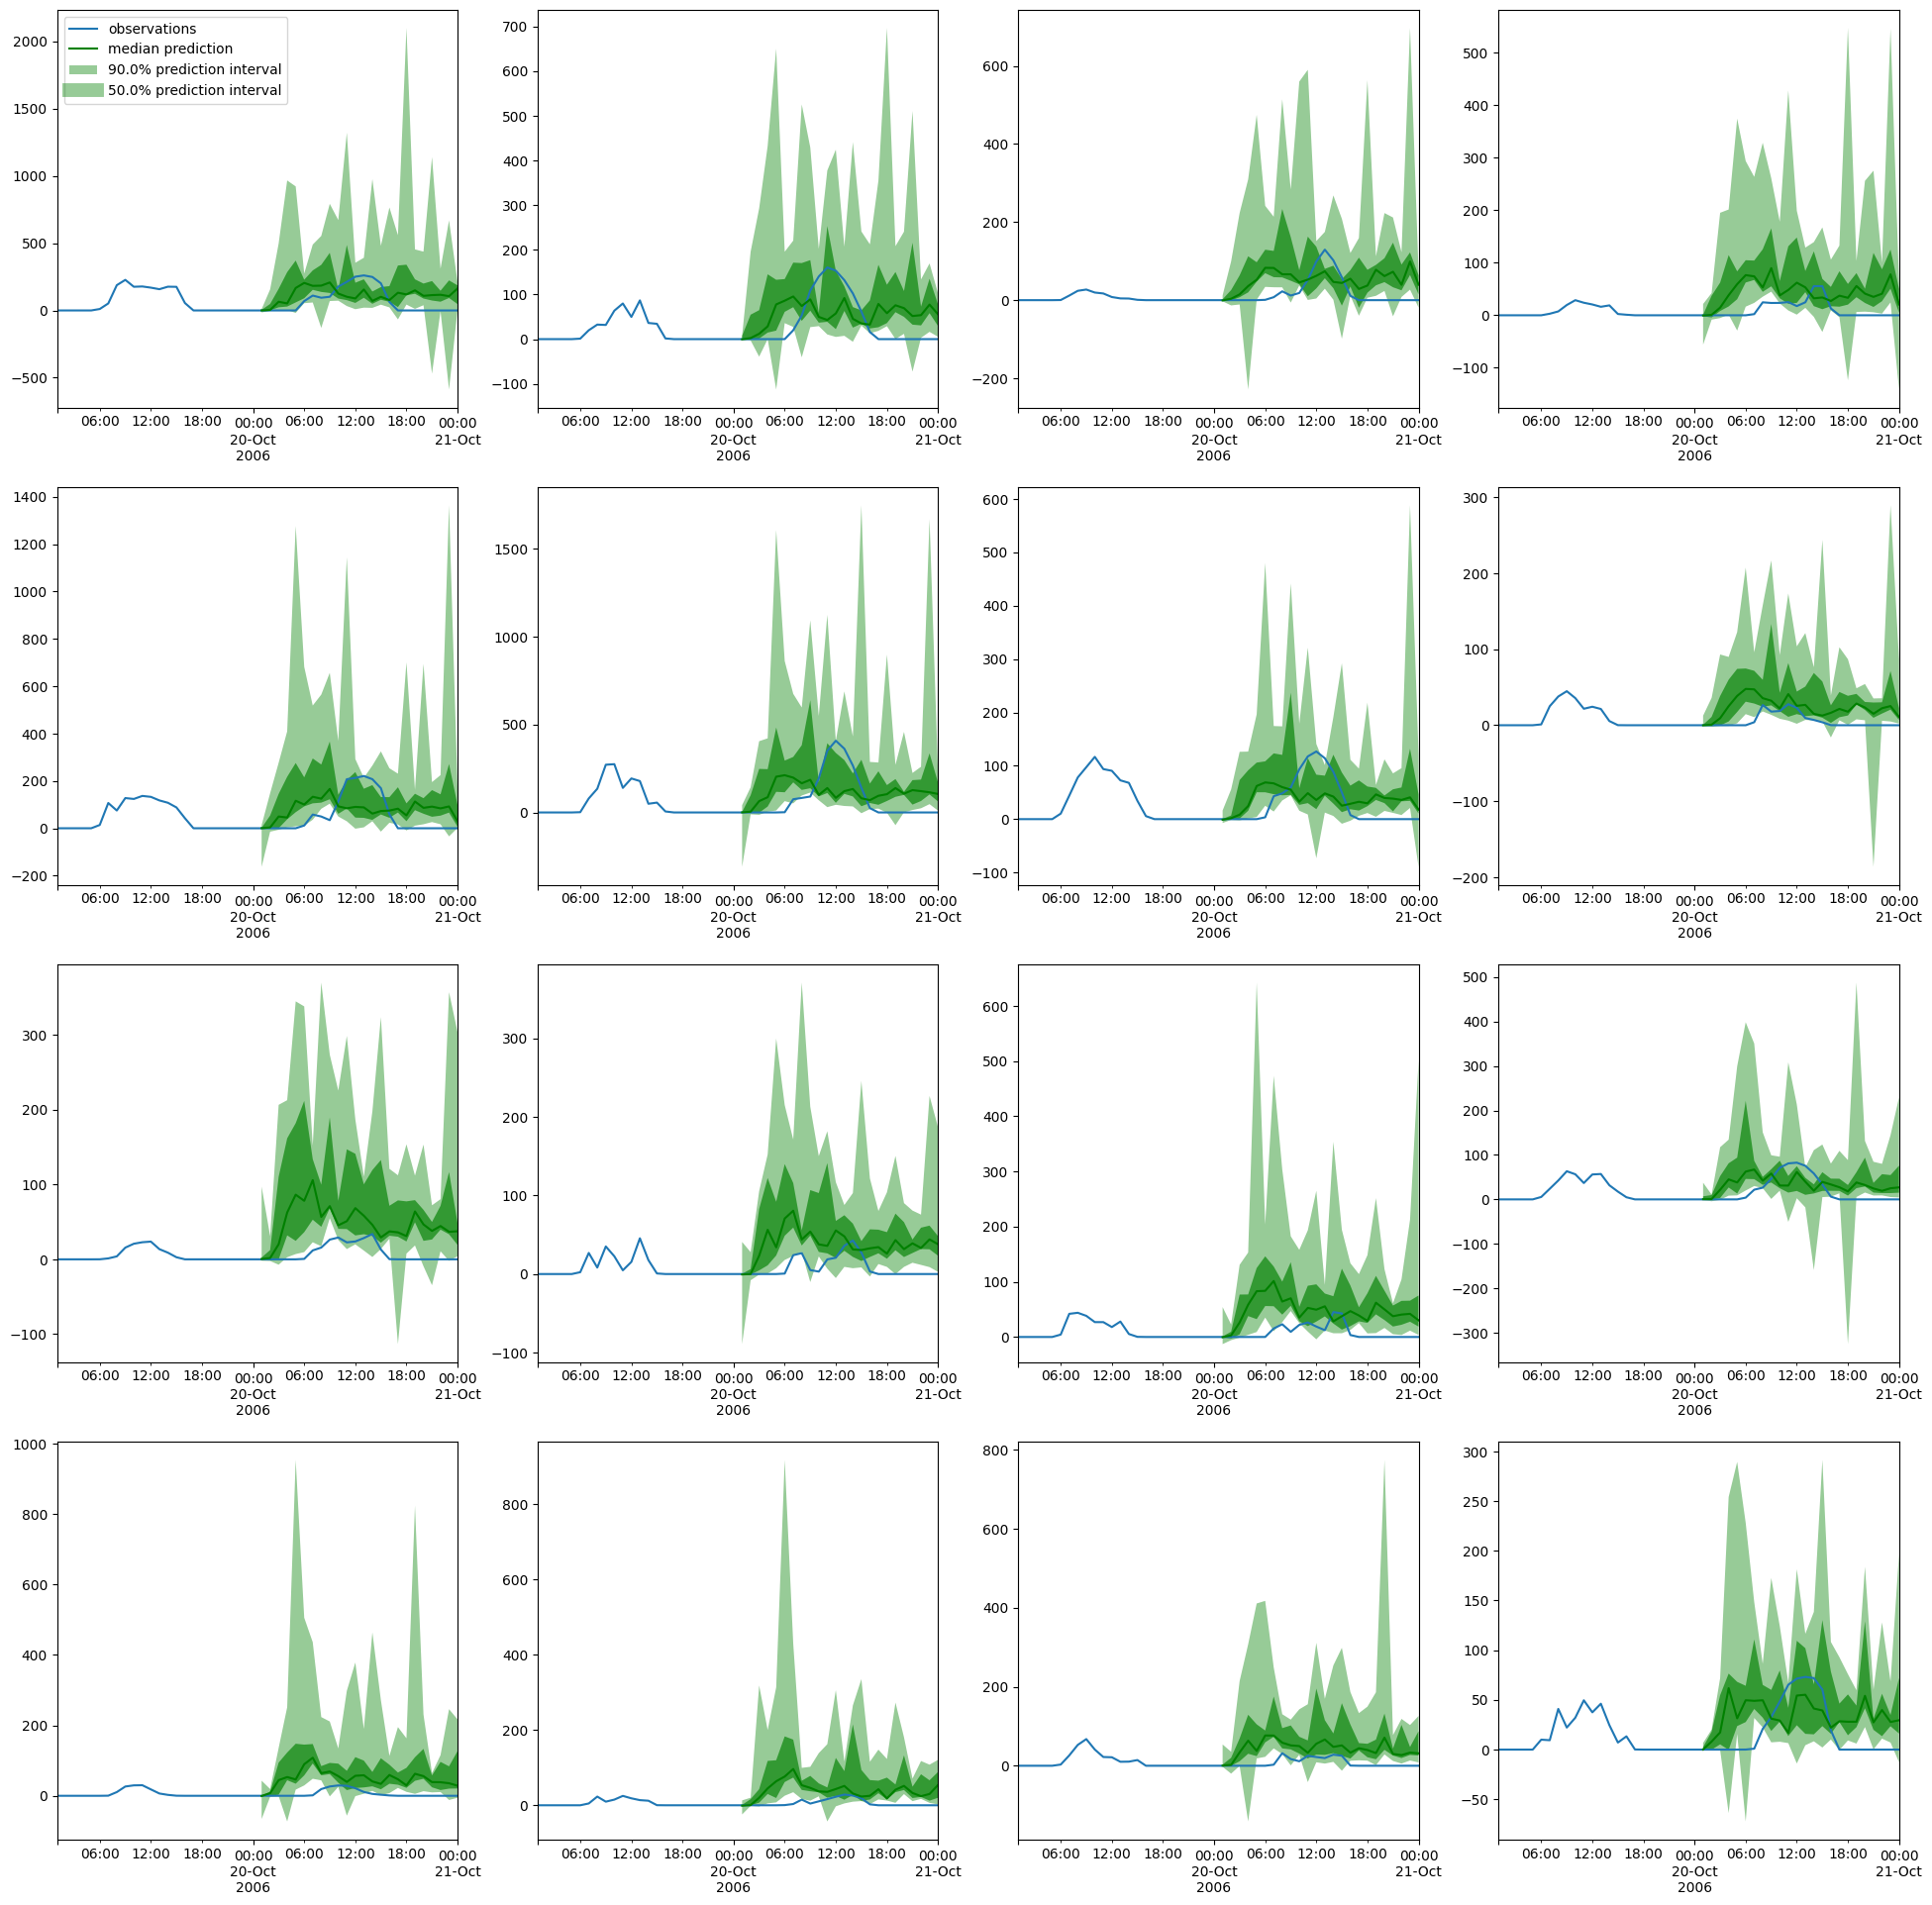

In [18]:
print("solar")

plot(
    target=targets_solar[0],
    forecast=forecasts_solar[0],
    prediction_length=dataset_solar.metadata.prediction_length,
)
plt.show()

# 评估

In [19]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

In [20]:
agg_metric_solar, item_metrics_solar = evaluator(targets_solar, forecasts_solar, num_series=len(dataset_test_solar))


Running evaluation: 7it [00:00, 93.22it/s]
Running evaluation: 7it [00:00, 120.24it/s]
Running evaluation: 7it [00:00, 122.09it/s]
Running evaluation: 7it [00:00, 124.51it/s]
Running evaluation: 7it [00:00, 125.03it/s]
Running evaluation: 7it [00:00, 124.15it/s]
Running evaluation: 7it [00:00, 124.78it/s]
Running evaluation: 7it [00:00, 124.70it/s]
Running evaluation: 7it [00:00, 125.84it/s]
Running evaluation: 7it [00:00, 125.65it/s]
Running evaluation: 7it [00:00, 126.05it/s]
Running evaluation: 7it [00:00, 126.34it/s]
Running evaluation: 7it [00:00, 125.86it/s]
Running evaluation: 7it [00:00, 125.48it/s]
Running evaluation: 7it [00:00, 124.10it/s]
Running evaluation: 7it [00:00, 124.33it/s]
Running evaluation: 7it [00:00, 125.43it/s]
Running evaluation: 7it [00:00, 123.82it/s]
Running evaluation: 7it [00:00, 126.90it/s]
Running evaluation: 7it [00:00, 125.60it/s]
Running evaluation: 7it [00:00, 124.91it/s]
Running evaluation: 7it [00:00, 125.80it/s]
Running evaluation: 7it [00:00, 1

In [21]:
print("solar Results")
print("CRPS:", agg_metric_solar["mean_wQuantileLoss"])
print("ND:", agg_metric_solar["ND"])
print("NRMSE:", agg_metric_solar["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric_solar["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric_solar["m_sum_ND"])
print("NRMSE-Sum:", agg_metric_solar["m_sum_NRMSE"])

solar Results
CRPS: 1.576807359591416
ND: 1.8437868812282932
NRMSE: 3.6258017099162982

CRPS-Sum: 1.9805400259760946
ND-Sum: 2.421476182218045
NRMSE-Sum: 3.0336512148368158
